In [1]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader
import seaborn
seaborn.set()
seaborn.set_style('ticks')

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import sys
import fracdiff
from fracdiff import FracDiff, StationarityTester, StationaryFracDiff

import importlib
importlib.reload(fracdiff)
%reload_ext autoreload
%autoreload

## Coefficient

In [2]:
n_samples = 6

a = np.r_[1, np.zeros(n_samples - 1)]
a

array([1., 0., 0., 0., 0., 0.])

ValueError: Parameter "order" must be 0-1, but 1.25 was given.

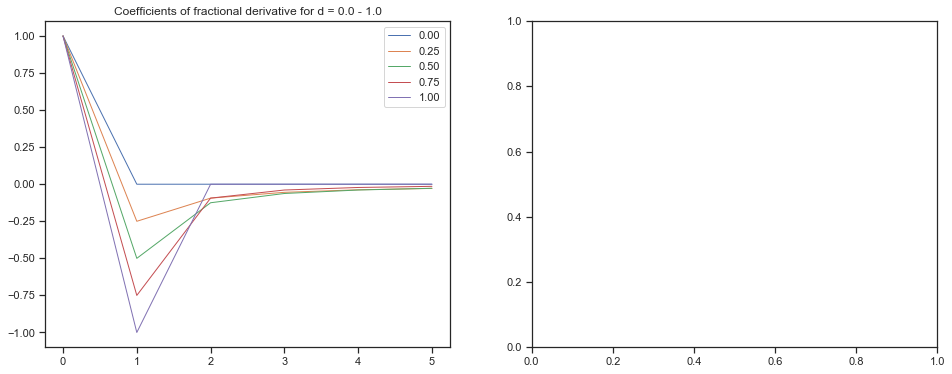

In [3]:
plt.figure(figsize=(16, 6))

def dict_a_d(lower, upper):
    return {
        order: FracDiff(order=order, window=-1).transform(a)
        for order in np.linspace(lower, upper, 5)
    }

title = 'Coefficients of fractional derivative for d = 0.0 - 1.0'
plt.subplot(1, 2, 1)
for order, a_d in dict_a_d(0.0, 1.0).items():
    plt.plot(a_d, label=f'{order:.2f}', linewidth=1)
plt.title(title)
plt.legend()

title = 'Coefficients of fractional derivative for d = 1.0 - 2.0'
plt.subplot(1, 2, 2)
for order, a_d in dict_a_d(1.0, 2.0).items():
    plt.plot(a_d, label=f'{order:.2f}', linewidth=1)
plt.title(title)
plt.legend()

plt.show()

## S&P 500

### Fetch data

In [ ]:
series_spx = pandas_datareader.data.DataReader('^GSPC', 'yahoo', '1998-01-01', '2018-12-31')['Adj Close']

spx_dates = series_spx.index
spx = series_spx.values
logspx = np.log(spx)

series_spx

### Fractional differentiation

In [ ]:
order, window = 0.5, 1000

spx_d = FracDiff(order, window=window).transform(logspx)
series_spx_d = pd.Series(spx_d, index=spx_dates)

series_spx_d

### Plot fractional differentiation with various orders

In [ ]:
window = 1000

plt.figure(figsize=(16, 16))
plt.tight_layout()
plt.subplots_adjust(hspace=0.6)

plt.subplot(6, 1, 1)
plt.plot(series_spx, linewidth=1)
plt.title('S&P 500')

for i, order in enumerate(np.linspace(0.2, 1.0, 5)):
    spx_d = FracDiff(order, window=window).transform(logspx)
    series_spx_d = pd.Series(spx_d, index=spx_dates)
    plt.subplot(6, 1, 2 + i)
    plt.title(f'S&P 500, differentiated with order {order:.1f}')
    plt.plot(series_spx_d, linewidth=0.4)

plt.show()

### Stationarity of fractionally differentiated S&P 500

In [ ]:
window = 1000

def adfstat(order):
    spx_d = FracDiff(order, window=window).transform(logspx)[window:]
    adf = StationarityTester().score(spx_d, value='statistics')
    return adf

def correlation(order):
    spx_d = FracDiff(order, window=window).transform(logspx)[window:]
    correlation = np.corrcoef(logspx[window:], spx_d)[0, 1]
    return correlation

# ADF statistics for orders in 0.0 - 1.0
orders = np.linspace(0.0, 1.0, 11)
adfstats = np.vectorize(adfstat)(orders)
correlations = np.vectorize(correlation)(orders)

# 5% critical value of stationarity
_, _, _, _, crit, _ = StationarityTester().score(logspx, value='all')
crit_5pc = crit['5%']

# plot
title = 'Stationarity and memory of fractionally differentiated S&P 500'
fig, ax_adf = plt.subplots(figsize=(16, 8))
ax_cor = ax_adf.twinx()

ax_adf.axhline(y=crit_5pc, linestyle='--', color='gray')
ax_adf.plot(orders, adfstats, color='blue', label='ADF statistics (left axis)')
ax_cor.plot(orders, correlations, color='orange', label='Correlation to original (right axis)')

plt.title(title)
fig.legend()
plt.show()

### Make time-series stationary by fractional differentiation

In [ ]:
statfracdiff = StationaryFracDiff(window=1000, precision=.01)
stationarity = StationarityTester()

# fit and transform
spx_d = statfracdiff.fit_transform(logspx)
order = statfracdiff.order_
pvalue = stationarity.score(spx_d[window:])

print(f'- Order: {order:.2f}')
print(f'- ADF p-value: {pvalue:.3f}')

# Plot
title = f'S&P 500, differentiated with order {order:.2f}'
plt.figure(figsize=(16, 8))
plt.plot(pd.Series(spx_d, index=spx_dates), linewidth=1)
plt.title(title)
plt.show()

### Other financial data

In [ ]:
tickers_yahoo = {
    'SPX': '^GSPC',
    'NKY': '^N225',
    'SHC': '^SSEC',
    'AAPL': 'AAPL',
}
tickers_fred = {
    'USDJPY': 'DEXJPUS',
    'GLD': 'GOLDPMGBD228NLBM',
    'OIL': 'DCOILWTICO',
}

prices_yahoo = pd.DataFrame({
    ticker: pandas_datareader.data.DataReader(symbol, 'yahoo', '1997-12-01', '2018-12-31')['Adj Close']
    for ticker, symbol in tickers_yahoo.items()
})
prices_fred = pd.DataFrame({
    ticker: pandas_datareader.data.DataReader(symbol, 'fred', '1997-12-01', '2018-12-31').iloc[:, 0]
    for ticker, symbol in tickers_fred.items()
})

prices = pd.concat([prices_yahoo, prices_fred], axis=1).fillna(method='ffill').loc['1998-01-02':]
logprices = prices.applymap(np.log)
logprices.head()

In [ ]:
orders = np.linspace(0.0, 1.0, 11)
window = 1000

def pvalues(logprice, orders):
    diffs = [
        FracDiff(order, window).transform(logprice.values)[window:]
        for order in orders
    ]
    return [StationarityTester().score(diff, value='statistics') for diff in diffs]

adfs = pd.DataFrame({
    ticker: pvalues(logprices[ticker], orders) for ticker in logprices.columns
}, index=orders)

adfs

In [ ]:
_, _, _, _, crit, _ = StationarityTester().score(logprices['SPX'].values, value='all')
crit_5pc = crit['5%']

title = 'ADF statistics of fractionally differentiated prices'
adfs.plot(figsize=(16, 8), ylim=(-20, 0))
plt.axhline(y=crit_5pc, linestyle='--', color='gray')
plt.title(title)
plt.show()